In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from PIL import Image
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:

## Path to the zipped file
zip_file_path = "/content/gdrive/MyDrive/data/dataset_finale/data_10thous.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

#path to the new data
## Path to the zipped file
zip_file_path_new = "/content/gdrive/MyDrive/data/dataset_finale/new_data.zip"
with zipfile.ZipFile(zip_file_path_new, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
frames_path = '/content/data_1/frames'
mask_path = '/content/data_1/mask'
all_frames = sorted(os.listdir(frames_path))
all_masks = sorted(os.listdir(mask_path))

print(len(all_masks))
print(len(all_frames))


8025
8674


In [ ]:
#new data
frames_path_new = '/content/new_data/frames'
mask_path_new = '/content/new_data/mask'
all_frames_new = sorted(os.listdir(frames_path_new))
all_masks_new = sorted(os.listdir(mask_path_new))

print(len(all_masks_new))
print(len(all_frames_new))

358
358


In [ ]:
frames_path = '/content/data_1/frames'
mask_path = '/content/data_1/mask'

# Get all file names in the directories
all_frames = [os.path.splitext(f)[0] for f in os.listdir(frames_path) if os.path.isfile(os.path.join(frames_path, f))]
all_masks = [os.path.splitext(f)[0] for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))]


# Convert lists to sets
set_frames = set(all_frames)
set_masks = set(all_masks)

# Use set intersection to find common elements
common = set_frames & set_masks

# Convert the set back to a list and sort it
common_list = sorted(list(common))



In [ ]:
###new data
import os
import shutil

frames_path_new = '/content/new_data/frames'
mask_path_new = '/content/new_data/mask'

# Get all file names in the directories
all_frames_new = [os.path.splitext(f)[0] for f in os.listdir(frames_path_new) if os.path.isfile(os.path.join(frames_path_new, f))]
all_masks_new = [os.path.splitext(f)[0] for f in os.listdir(mask_path_new) if os.path.isfile(os.path.join(mask_path_new, f))]


# Convert lists to sets
set_frames_new = set(all_frames_new)
set_masks_new = set(all_masks_new)

# Use set intersection to find common elements
common_new = set_frames_new & set_masks_new

# Convert the set back to a list and sort it
common_list_new = sorted(list(common_new))
print(common_list_new)


['frame_0001', 'frame_0002', 'frame_0003', 'frame_0004', 'frame_0005', 'frame_0006', 'frame_0007', 'frame_0008', 'frame_0009', 'frame_0010', 'frame_0011', 'frame_0012', 'frame_0013', 'frame_0014', 'frame_0015', 'frame_0016', 'frame_0017', 'frame_0018', 'frame_0019', 'frame_0020', 'frame_0021', 'frame_0022', 'frame_0023', 'frame_0024', 'frame_0025', 'frame_0026', 'frame_0027', 'frame_0028', 'frame_0029', 'frame_0030', 'frame_0031', 'frame_0032', 'frame_0033', 'frame_0034', 'frame_0035', 'frame_0036', 'frame_0037', 'frame_0038', 'frame_0039', 'frame_0040', 'frame_0041', 'frame_0042', 'frame_0043', 'frame_0044', 'frame_0045', 'frame_0046', 'frame_0047', 'frame_0048', 'frame_0049', 'frame_0050', 'frame_0051', 'frame_0052', 'frame_0053', 'frame_0054', 'frame_0055', 'frame_0056', 'frame_0057', 'frame_0058', 'frame_0059', 'frame_0060', 'frame_0061', 'frame_0062', 'frame_0063', 'frame_0064', 'frame_0065', 'frame_0066', 'frame_0067', 'frame_0068', 'frame_0069', 'frame_0070', 'frame_0071', 'fram

In [ ]:

from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import keras

class ImageDataLoader(keras.utils.Sequence):
    def __init__(self, common_list, frames_path, mask_path, frames_path_new, mask_path_new, batch_size=8, image_size=400):
        self.common_list = common_list
        self.frames_path = frames_path
        self.mask_path = mask_path
        self.frames_path_new = frames_path_new
        self.mask_path_new = mask_path_new
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, filename):
        # Check if the filename is in the new data list
        if filename in all_frames_new:
            frame_path = self.frames_path_new
            mask_path = self.mask_path_new
        else:
            frame_path = self.frames_path
            mask_path = self.mask_path

        # Load and preprocess the frame
        frame_image = cv2.imread(os.path.join(frame_path, filename + '.jpg'))
        final_frame = cv2.resize(frame_image, (self.image_size, self.image_size))
        final_frame = final_frame / 255.0

        # Load and preprocess the mask
        mask_image = cv2.imread(os.path.join(mask_path, filename + '.png'))
        gray_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
        _, result_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY_INV)
        result_mask = cv2.resize(result_mask, (self.image_size, self.image_size))
        result_mask = np.expand_dims(result_mask, axis=-1)
        result_mask = result_mask / 255.0

        return final_frame, result_mask

    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.common_list):
            self.batch_size = len(self.common_list) - index*self.batch_size

        filenames = self.common_list[index*self.batch_size : (index+1)*self.batch_size]

        images = []
        masks = []

        for filename in filenames:
            _img, _mask = self.__load__(filename)
            images.append(_img)
            masks.append(_mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

    def on_epoch_end(self):

      self.indices = np.arange(len(self.common_list))



    def __len__(self):
        return int(np.ceil(len(self.common_list)/float(self.batch_size)))


In [ ]:
# Split the new data into 90% for training and validation and 10% for testing
common_list_temp_new, common_list_test_new = train_test_split(common_list_new, test_size=0.1, shuffle=False, random_state=42)
# Further split the 90% into 78% training and 22% validation
common_list_train_new, common_list_val_new = train_test_split(common_list_temp_new, test_size=0.22, shuffle=True, random_state=42)
# Split the data into 90% for training and validation and 10% for testing
common_list_temp, common_list_test = train_test_split(common_list, test_size=0.1, shuffle=False, random_state=42)
# Further split the 90% into 78% training and 22% validation
common_list_train, common_list_val = train_test_split(common_list_temp, test_size=0.22, shuffle=True, random_state=42)


# Concatenate the training lists
common_list_train_total = common_list_train + common_list_train_new

# Concatenate the validation lists
common_list_val_total = common_list_val + common_list_val_new

# Concatenate the testing lists
common_list_test_total = common_list_test + common_list_test_new


'\ntrain_loader = ImageDataLoader(common_list_train_total, frames_path, mask_path, frames_path_new, mask_path_new)\nval_loader = ImageDataLoader(common_list_val_total, frames_path, mask_path, frames_path_new, mask_path_new)\ntest_loader = ImageDataLoader(common_list_test_total, frames_path, mask_path, frames_path_new, mask_path_new)\n\n'

In [ ]:
x, y = train_loader.__getitem__(0)
print(x.shape, y.shape)


(8, 400, 400, 3) (8, 400, 400, 1)


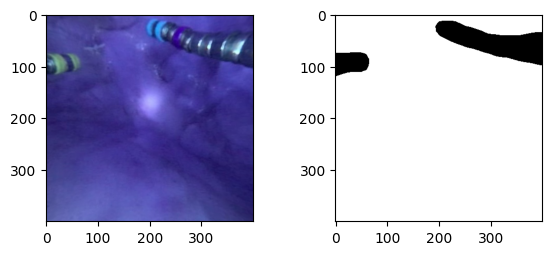

In [ ]:
r = random.randint(0, len(x)-1)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)

ax.imshow(np.reshape(y[r], (400,400)), cmap="gray")

['frame_12641', 'frame_11945', 'frame_13011', 'frame_6910', 'frame_8787', 'frame_12521', 'frame_11170', 'frame_7826', 'frame_6286', 'frame_11649', 'frame_14035', 'frame_6605', 'frame_11323', 'frame_6474', 'frame_12083', 'frame_12662', 'frame_12087', 'frame_12473', 'frame_14351', 'frame_10387', 'frame_14598', 'frame_11032', 'frame_14643', 'frame_14951', 'frame_11965', 'frame_13281', 'frame_8650', 'frame_7997', 'frame_12117', 'frame_11010', 'frame_7991', 'frame_10931', 'frame_13185', 'frame_10691', 'frame_10533', 'frame_6864', 'frame_6265', 'frame_14770', 'frame_10652', 'frame_10033', 'frame_7151', 'frame_10044', 'frame_14202', 'frame_7822', 'frame_10964', 'frame_13949', 'frame_13611', 'frame_7938', 'frame_12392', 'frame_6703', 'frame_14468', 'frame_8685', 'frame_13225', 'frame_6536', 'frame_12446', 'frame_12835', 'frame_10026', 'frame_7994', 'frame_10063', 'frame_11044', 'frame_14427', 'frame_14989', 'frame_13762', 'frame_11454', 'frame_10227', 'frame_6848', 'frame_13666', 'frame_9074',

In [ ]:
def down(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((400, 400, 3))

    p0 = inputs
    c1, p1 = down(p0, f[0]) 
    c2, p2 = down(p1, f[1]) 
    c3, p3 = down(p2, f[2]) 
    c4, p4 = down(p3, f[3]) 

    bn = bottleneck(p4, f[4])

    u1 = up(bn, c4, f[3]) 
    u2 = up(u1, c3, f[2]) 
    u3 = up(u2, c2, f[1]) 
    u4 = up(u3, c1, f[0]) 

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

common_list_total = common_list_train_total + common_list_val_total

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state = 42)
accuracy_list= []
loss_list = []

for fold, (train_index, val_index) in enumerate(kf.split(common_list_total)):
    print(f"Training fold {fold+1}...")

    # Split the data into training and validation sets
    common_list_train_fold = [common_list_total[i] for i in train_index]
    common_list_val_fold = [common_list_total[i] for i in val_index]
    #print(common_list_train_fold)
    # Create data loaders for this fold
    train_loader = ImageDataLoader(common_list_train_fold, frames_path, mask_path, frames_path_new, mask_path_new)
    val_loader = ImageDataLoader(common_list_val_fold, frames_path, mask_path, frames_path_new, mask_path_new)

    # Debugging the loaders
    for data in train_loader:
        print(f"Sample train data shape: {data[0].shape}, label shape: {data[1].shape}")
        break

    for data in val_loader:
        print(f"Sample val data shape: {data[0].shape}, label shape: {data[1].shape}")
        break

    train_steps = len(train_loader)//8
    valid_steps = len(val_loader)//8

    # Check dataset size to avoid running out of data
    if train_steps == 0 or valid_steps == 0:
        print(f"Insufficient data for fold {fold+1}, skipping...")
        continue

    # Check dataset size to avoid running out of data
    if train_steps == 0 or valid_steps == 0:
        print(f"Insufficient data for fold {fold+1}, skipping...")
        continue

    model = UNet()
    cb_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
    cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-5)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc", tf.keras.metrics.Recall(thresholds=0)])

    try:
        history = model.fit(train_loader, validation_data=val_loader, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=100,callbacks=[cb_early_stop, cb_lr])
        accuracy_list.append(history.history['val_acc'][-1])
        loss_list.append(history.history['val_loss'][-1])
    except Exception as e:
        print(f"An error occurred during fold {fold+1}: {str(e)}")


        continue

average_accuracy = np.mean(accuracy_list)
average_loss = np.mean(loss_list)

print(f'Average accuracy over {k} folds: {average_accuracy}')
print(f'Average loss over {k} folds: {average_loss}')


Training fold 1...
Sample train data shape: (8, 400, 400, 3), label shape: (8, 400, 400, 1)
Sample val data shape: (8, 400, 400, 3), label shape: (8, 400, 400, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - acc: 0.9336 - loss: 0.3457 - recall: 1.0000 - val_acc: 0.9817 - val_loss: 0.0565 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 315ms/step - acc: 0.9851 - loss: 0.0384 - recall: 1.0000 - val_acc: 0.9917 - val_loss: 0.0213 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - acc: 0.9928 - loss: 0.0185 - recall: 1.0000 - val_acc: 0.9929 - val_loss: 0.0188 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - acc: 0.9929 - loss: 0.0176 - recall: 1.0000 - val_acc: 0.9954 - val_loss: 0.0115 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - acc: 0.9943 - loss: 0.0150 - recall: 1.0000 - val_acc: 0.9939 - val_loss: 0.0148 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - acc: 0.9943 - loss: 0.0146 - recal

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - acc: 0.9924 - loss: 0.0178 - recall: 1.0000 - val_acc: 0.9906 - val_loss: 0.0322 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - acc: 0.9919 - loss: 0.0219 - recall: 1.0000 - val_acc: 0.9946 - val_loss: 0.0134 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - acc: 0.9930 - loss: 0.0176 - recall: 1.0000 - val_acc: 0.9953 - val_loss: 0.0111 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 12/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - acc: 0.9945 - loss: 0.0140 - recall: 1.0000 - val_acc: 0.9959 - val_loss: 0.0102 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 13/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - acc: 0.9955 - loss: 0.0115 - recall: 1.0000 - val_acc: 0.9956 - val_loss: 0.0110 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 14/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - acc: 0.9955 - loss: 0.0114 - re

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc",tf.keras.metrics.Recall(thresholds=0)])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 400, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 400, 400, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 400, 400, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 200, 200, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 200, 200, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 200, 200, 32)   │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 100, 100, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 100, 100, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 100, 100, 64)   │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 50, 50, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 50, 50, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 50, 50, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 25, 25, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 25, 25, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 25, 25, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 50, 50, 256)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 50, 50, 384)    │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 1,962,625 (7.49 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# When you want to use the model
from keras.models import load_model

# Create a generator for the test data
test_loader = ImageDataLoader(common_list_test_total, frames_path, mask_path, frames_path_new, mask_path_new)
# Evaluate the model on the test data
results = model.evaluate(test_loader)

print("Test loss, Test accuracy:", results)



105/105 [==============================] - 11s 104ms/step - loss: 0.0654 - acc: 0.9898 - recall: 1.0000
Test loss, Test accuracy: [0.06544793397188187, 0.9897656440734863, 1.0]
